In [17]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data

CMB_map_path = '/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_044_mc_0000.fits'
CMB_data_30 = skyclean.CMB_data.CMB_Data(CMB_map_path)

# Store get mw alm
CMB_data_30.original_hp_alm = hp.map2alm(CMB_data_30.original_hp_map, lmax=CMB_data_30.lmax-1)
CMB_data_30.original_mw_alm = CMB_data_30.hp_alm_to_mw_alm(CMB_data_30.original_hp_alm, lmax=CMB_data_30.lmax)


# Create Beam Window Functions for LFI channels
# Frequencies for LFI channels (in GHz)
frequencies = [30, 44, 70]
# Beam FWHM for each frequency (in arcminutes)
beam_fwhm = {30: 32.33, 44: 27.01, 70: 13.25}

# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

# Define a range of l values
lmax = CMB_data_30.lmax

fwhm_rad = arcmin_to_radians(beam_fwhm[30])
bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)

print(bl.shape)

# To make sure the noise doesn't blow up, we threshold the beam window function
print(bl.min())
thresholded_bl = bl.copy()
thresholded_bl[thresholded_bl < 1e-3] = 1e-3
print(thresholded_bl.min())

# Deconvolve the beam window function from the CMB data
CMB_data_30_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_beam_deconvolved[:, i] = CMB_data_30.original_mw_alm[:, i] / thresholded_bl
CMB_data_30_beam_deconvolved.shape
# print(CMB_data_30_beam_deconvolved)

CMB_Data object created, (use show_attributes() to check the attributes)
(2048,)
3.023745925110047e-15
0.001


(2048, 4095)

In [18]:


def vertical_operation(mw_alm, bl,operation):
    """
    Perform a vertical operation of each column of the original_mw_alm matrix by the thresholded_bl vector.
    
    Parameters:
    original_mw_alm (ndarray): The original matrix to be divided.
    thresholded_bl (ndarray): The vector by which each column of the matrix will be divided.
    
    Returns:
    ndarray: A new matrix with each column of original_mw_alm divided by thresholded_bl.
    """
    # # Ensure thresholded_bl is a column vector for broadcasting
    # thresholded_bl = thresholded_bl[:, np.newaxis]
    
    # # Perform the division
    # beam_deconvolved = original_mw_alm / thresholded_bl
    beam_deconvolved = np.zeros(mw_alm.shape)

    if operation == '*':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] * bl
    elif operation == '/':
        for i in range(mw_alm.shape[1]):
            beam_deconvolved[:, i] = mw_alm[:, i] / bl
    else:
        raise ValueError("Operation must be '*' or '/'")


    return beam_deconvolved

# Example usage
# Assuming CMB_data_30.original_mw_alm and thresholded_bl are already defined
CMB_data_30_beam_deconvolved_1 = vertical_operation(CMB_data_30.original_mw_alm, thresholded_bl,"/")

# Check the shape
print(CMB_data_30_beam_deconvolved==CMB_data_30_beam_deconvolved_1)


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [19]:
# Get the Pixel Window Function for the specified nside
pixwin = hp.sphtfunc.pixwin(CMB_data_30.nside, lmax=CMB_data_30.lmax-1, pol=False)

print(pixwin.shape)
print(pixwin.min())

(2048,)
0.8274355847005429


In [20]:
CMB_data_30_pix_beam_deconvolved = np.zeros(CMB_data_30.original_mw_alm.shape)

for i in range(CMB_data_30.original_mw_alm.shape[1]):
    CMB_data_30_pix_beam_deconvolved[:, i] = CMB_data_30_beam_deconvolved[:, i] / pixwin
CMB_data_30_pix_beam_deconvolved.shape

(2048, 4095)

In [21]:
fwhm_rad = arcmin_to_radians(5)
Standard_bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=CMB_data_30.lmax-1, pol=False)

print(Standard_bl.shape)

(2048,)


In [22]:
deconvolved_CMB_data_30 = np.zeros(CMB_data_30.original_mw_alm.shape)   


for i in range(CMB_data_30.original_mw_alm.shape[1]):
    deconvolved_CMB_data_30[:, i] = CMB_data_30_pix_beam_deconvolved[:, i] * Standard_bl
deconvolved_CMB_data_30.shape

(2048, 4095)

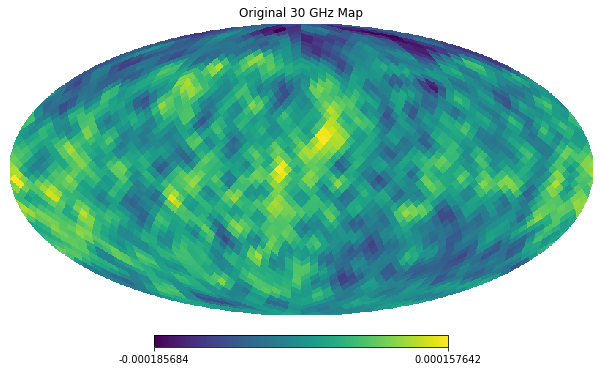

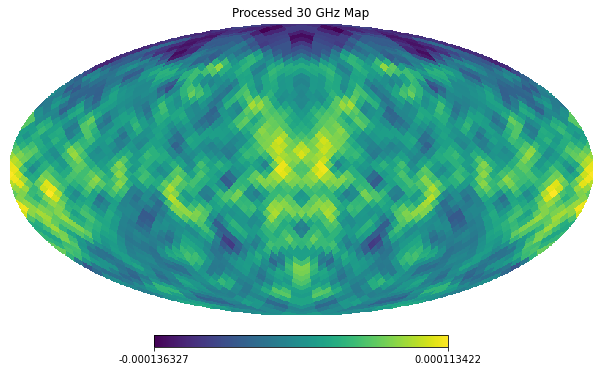

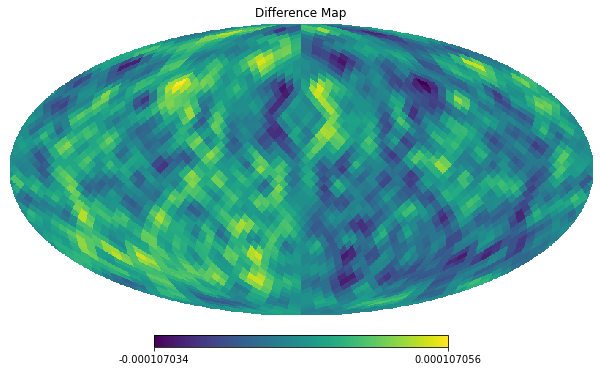

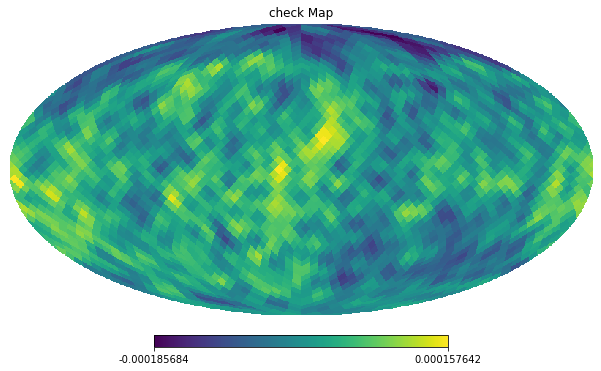

In [30]:
processed_30_hp_alm = CMB_data_30.mw_alm_to_hp_alm(deconvolved_CMB_data_30, lmax=CMB_data_30.lmax)

# processed_30_hp_map = hp.alm2map(processed_30_hp_alm, nside=CMB_data_30.nside, lmax=CMB_data_30.lmax-1)
# processed_30_hp_map = hp.alm2map(processed_30_hp_alm, nside=, lmax=32)

processed_30_hp_map = hp.alm2map(hp.map2alm(hp.alm2map(processed_30_hp_alm, nside=CMB_data_30.nside, lmax=CMB_data_30.lmax-1),32), 16,32)


hp.mollview(hp.alm2map(hp.map2alm(CMB_data_30.original_hp_map,32), 16,32), title='Original 30 GHz Map')
hp.mollview(processed_30_hp_map, title='Processed 30 GHz Map')

hp.mollview(hp.alm2map(hp.map2alm(CMB_data_30.original_hp_map,32), 16,32) - processed_30_hp_map, title='Difference Map')

hp.mollview(processed_30_hp_map+(hp.alm2map(hp.map2alm(CMB_data_30.original_hp_map,32), 16,32) - processed_30_hp_map), title='check Map')
# CMB_data_30.plot_mollview(processed_30_hp_map+(CMB_data_30.original_hp_map - processed_30_hp_map), title='check Map')